<a href="https://colab.research.google.com/github/karthajee/AWS-IF-interpretability/blob/main/AWS_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

The purpose of the experiments is three-fold:

1.   Does our method provide accurate local explanations
for examples flagged as anomalies?
2.   Is our method more efficient than comparable state-of-the-art methods like [SHAP](https://github.com/slundberg/shap)?
3.   What are the key differences between local-DIFFI (conceptualized by authors of the paper [Interpretable Anomaly Detection with DIFFI: Depth-based Feature Importance for the Isolation Forest](https://arxiv.org/pdf/2007.11117.pdf)) and our method?

We run our experiments on both synthetic and real-world data. The synthetic data consist of multiple settings of normally distributed point clusters wherein we systematically vary dataset size (from 1,000 to 10,000), dimensionality (from 2 to 50), and the proportion of attributes randomly chosen examples are made anomalous across (till 100%). For the sake of consistency, the six real-world data are the same datasets as used in the DIFFI paper.



## Experimental Setup

The fundamental design issue with explainability experiments is the absence of a ground truth to evaluate the predictions of the methods. Hence, we design the following procedure that simulates a ground-truth. 

Given a dataset consisting only of normal examples and an IFOREST trained on these data, we randomly pick $n$ examples
with replacement and for each example:

1.   obtain an initial explanation vector $w_0$
2.   randomly select a coalition of $m%$ of the example’s attributes
3.   for each of those, change its value to the 3∗max value of that particular attribute’s full range over all the data
4.   obtain a new explanation vector $w_{new}$ for the modified example
5.   compute the change between the initial and new explanations as $w = w_0 − w_{new}$ and normalize $w$. 

We now expect the change in explanation to occur only for the coalition of attributes that we changed, captured by the expected explanation vector $w_e$. This allows us to compute the root mean squared error (RMSE) between vectors $w$ and $w_e$. 

For instance, if we change the value of only one attribute in steps (2) and (3), we would expect 100% of the change in the explanation to occur for this particular attribute, reflected in vector $w$. Finally, we average the errors over all n randomly picked examples. We alsocompute the RMSE for a random explanation vector.


# Imports & Setting Up

In [ ]:
#Install required files for SHAP
!pip install shap

In [ ]:
#Save exp plots and files
from google.colab import drive
drive.mount('/content/gdrive')

#Change to False if exp files not to be saved
save_files = True

Mounted at /content/gdrive


In the next code block, we install the required libraries for local DIFFI, as outlined in the paper [Interpretable Anomaly Detection with DIFFI: Depth-based Feature Importance for the Isolation Forest](https://arxiv.org/pdf/2007.11117.pdf).


In [ ]:
import os, sys
os.chdir('/content')
if not(os.path.exists('DIFFI')):
  !git clone https://github.com/mattiacarletti/DIFFI.git
  %cd DIFFI
  !python utils.py install
  !python sklearn_mod_functions.py install
  !python interpretability_module.py install
  sys.path.append(os.getcwd())

Cloning into 'DIFFI'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 31 (delta 5), reused 6 (delta 2), pack-reused 0
Unpacking objects: 100% (31/31), done.
/content/DIFFI


In [ ]:
#Core Imports for experiments
import shap
import numpy as np
import pandas as pd 
import math
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
from statistics import mean
from sklearn.datasets import make_blobs
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from operator import truediv
from collections import defaultdict
import time

#Imports for saving exp files
from datetime import datetime
import json
import pickle

#Imports to parallelize experiment iterations 
from multiprocessing import cpu_count
from multiprocessing import Pool

#DIFFI Imports
import utils
import sklearn_mod_functions
import interpretability_module as interp

In [ ]:
#Suppress deprecation warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Define global variables 
seed_val = 42
base_path = '/content/gdrive/My Drive/Experiments'

#Controls save location for exp files
now = datetime.now()
date_time = now.strftime("%d-%m, %H:%M")
dir_path = base_path + os.path.sep + date_time
os.mkdir(dir_path)
os.chdir(dir_path)

# Generating Explanations

In this section, we define the functions that generate explanation vectors as per the 3 methodologies under evaluation:

1.  AWS (*Our method*)
2.  Local DIFFI
3.  SHAP

## AWS

In [ ]:
def generate_aws_explanations(IF, dataset, verbose=False, 
                              mode="original", check_bag=False, normalize=False):

  """
  Returns a list of AWS explanation vectors.

  Also, returns lists of ordering indices (for plotting) and execution time
  per instance, for the passed dataset.

  Parameters
  ----------
  IF :  Isolation Forest
      The fit Isolation Forest instance 
  dataset : numpy array
      The instances that need to be explained
  verbose : bool, optional
      A flag used to print regular status updates
  mode: str, optional
      (Ignore) A flag used to control the explanation behaviour
  check_bag: bool, optional
      A flag used to check only those Isolation Trees containing the instance 
  normalize: bool, optional
      A flag used to normalize the returned vectors s.t. they add to 1

  """

  #Initialize the result lists
  aws_scores_l = []
  ord_idx_l= []
  exec_time_l = []

  #Iterate over each passed instance 
  for i, data in enumerate(dataset):

    #Generate the explanation and execution time for an instance
    aws_scores, exec_time = point_aws_explanation(IF, data, check_bag, mode)

    #Append the results to the results list
    aws_scores_l.append(aws_scores)
    ord_idx_l.append(np.argsort(aws_scores)[::-1])
    exec_time_l.append(exec_time)
  
  #Normalize results depending on the flag value
  if normalize:
    for i, score in enumerate(aws_scores_l):
      rowsum = np.sum(score)
      aws_scores_l[i] = score/rowsum

  return aws_scores_l, ord_idx_l, exec_time_l

In [ ]:
def point_aws_explanation(model, data, check_bag, mode):

  """
  Returns AWS explanation vector for a single instance.

  Parameters
  ----------
  IF :  Isolation Forest
      The fit Isolation Forest instance 
  data : numpy vector
      The specific instance that need to be explained
  check_bag: bool, optional
      A flag used to check only those Isolation Trees containing the instance 
  mode: str, optional
      (Ignore) A flag used to control the explanation behaviour
  """

  #Start tracking execution time
  start = time.time()

  #Initialize the vector that will store the explanation weights
  feature_relevance = np.zeros(shape=data.shape)

  #Iterate over each Isolation Tree of the passed IF model
  for i, estimator in enumerate(model.estimators_):

    #Get the path that the sample has taken
    node_indicator = estimator.decision_path(np.atleast_2d(data))
    node_ids = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]

    #Get the split features of all nodes that sample passes through
    splits_feature = estimator.tree_.feature[node_ids][:-1]
    
    #Get the size of all nodes that sample passes through
    node_sizes = estimator.tree_.n_node_samples[node_ids]

    #Calculate the relevance of each split as per AWS
    splits_parent = node_sizes[:-1]
    splits_child = node_sizes[1:]
    
    #IGNORE: Deprecated - part of older codebase
    if mode == 'diffi':
      multiplier = (1/len(node_ids) - 1/np.ceil(np.log2(model.max_samples)))
      splits_relevance = np.multiply(np.log2(splits_parent/splits_child), multiplier)
    
    #This part of the conditional is used for AWS
    elif mode == 'clement':
      term = np.log2(splits_parent / splits_child) - 1
      splits_relevance = term
    
    #IGNORE: Deprecated - part of older codebase
    else:
      splits_relevance = np.log2(splits_parent / splits_child)

    #Compute non-normalised feature importance of the tree
    #But first, get the array of unique features & their corresponding indices
    for f in np.nditer(np.unique(splits_feature)):
        feature_relevance[f] += np.mean(splits_relevance[np.where(splits_feature == f)[0]])    

  #Stop tracking execution time
  end = time.time()
  exec_time = end - start
  
  return feature_relevance, exec_time

## Local DIFFI

In [ ]:
def generate_diffi_explanations(model, dataset):
  
  """
  Returns a list of Local DIFFI explanation vectors.

  Also, returns lists of ordering indices (for plotting) and execution time
  per instance, for the passed dataset.

  Parameters
  ----------
  model :  Isolation Forest
      The fit Isolation Forest instance 
  dataset : numpy array
      The instances that need to be explained
  """

  #Produce the explanation vectors as per official DIFFI function
  diffi_l, ord_idx_l, exec_time_l = utils.local_diffi_batch(model, dataset)
  return diffi_l, ord_idx_l, exec_time_l

## SHAP

In [ ]:
def generate_shap_explanations(model, dataset):
  
  """
  Returns a list of SHAP explanation vectors.

  Also, returns lists of ordering indices (for plotting) and execution time
  per instance, for the passed dataset.

  Parameters
  ----------
  model :  Isolation Forest
      The fit Isolation Forest instance 
  dataset : numpy array
      The instances that need to be explained
  """

  ##Initialize the result lists
  shap_values_l = []
  ord_idx_l= []
  exec_time_l = []

  #Iterate over each passed instance 
  for i, data in enumerate(dataset):
    
    #Start tracking execution time
    start = time.time()

    #Generate the SHAP explanation for an instance
    explainer = shap.TreeExplainer(model, feature_perturbation='tree_path_dependent')
    shap_values = explainer.shap_values(data)
    
    #Stop tracking execution time
    end = time.time()  
    exec_time = end - start

    #Append the results to the results list
    shap_values_l.append(shap_values)
    ord_idx_l.append(np.argsort(shap_values)[::-1])
    exec_time_l.append(exec_time)

  return shap_values_l, ord_idx_l, exec_time_l

#Experiment Functions

As per the methodology outlined in the overview, this section houses the relevant functions to:


1.   Generate normal datasets.
2.   Convert randomly chosen normal instances from the dataset to anomalies.
3.   Compute and normalize the difference between expected and actual explanation vectors.
4.  Generate random explanations as a baseline
5.  Generate ground truth for explanations of selected anomalies
6. Evaluate RMSE loss between actual and expected explanation vectors.
7. Run the experiments.
8. Save the results.
9. Plot the results.



##Normal Dataset Generator

In [ ]:
def generate_normal_points(points=1000, dimensionality=2, clusters=1, max=20, random_state=42):
  
  """
  Returns a dataset of normal instances.

  Normal instances are grouped into a certain number of clusters.

  Parameters
  ----------
  points : int
      The number of normal instances to be produced
  dimensionality : int
      The number of features of the dataset
  clusters : int
      The number of clusters normal instances are grouped into
  max : int
      A variable that controls range of values from which samples are drawn
  random_state: int
      Setting the random seed for the sampling process
  """

  X, _ = make_blobs(n_samples=points, n_features=dimensionality, 
                             centers=clusters, random_state=random_state, 
                             center_box=(0, max))
  return X

##Anomalising the Normal Dataset

In [ ]:
def anomaliser(dataset, indices, n=1, r_mode='t'):

  """
  Converts the passed normal dataset into an anomalised dataset.

  For the passed instances, certain attributes are randomly but systematically
  picked and their values along these attributes are set to be anomalous.
  
  Parameters
  ----------
  dataset:  numpy array
      The normal dataset
  indices: numpy vector
      The indices of the normal instances, picked to be anomalised
  n : int
      The features of the normal dataset
  r_mode : str
      (Ignore) A flag used to control the behaviour of the anomaliser

  """

  #For each index, randomly pick a feature OR a combination of n features
  N = range(0, n)
  if r_mode == 't':
    setting_l = random.choices(N, k=len(indices))
  else:
    setting_l = [n-1] * len(indices)
  
  
  #Generate a list of list of attributes, where each inner list contains
  #the attributes along which the instances will be anomalised across
  picked_l = [random.sample(range(dataset.shape[1]), setting+1) for setting in setting_l]

  #Make the instances anomalous across those feature(s). We use noise in the 
  #multiplicand to ensure that the anomalous points do not have same values
  ano_rand_points = np.array([[np.random.normal(3, 0.3) * np.amax(dataset[:,el]) if el in picked 
                            else dataset[index, el] for el in range(dataset.shape[1])]
                            for (index, picked) in zip(indices, picked_l)])

  #Create a copy of the dataset and save the points
  new_dataset=np.copy(dataset)
  new_dataset[indices]=ano_rand_points
  
  return new_dataset, setting_l, picked_l

##Generating the Normalised Difference Vector 

In [ ]:
def generate_normed_diff(m1, m2):

  """
  Returns the normalised row-wise difference of 2 matrix.

  Parameters
  ----------
  m1 : numpy matrix
      The first matrix
  m2 : numpy matrix
      The second matrix, which is to be subtracted from the first matrix
  """

  #Calculate the difference between the 2 matrices
  diff = m2 - m1

  #We make negative elements in the difference matrix to be positive.
  #This is to make normalization possible as otherwise, all positive
  #elements will be set to 1 and all negative elements will be set to 0.
  pos_diff = np.abs(diff)
  
  #Normalize the difference matrix
  row_sum = np.sum(pos_diff, axis=1)
  norm_diff = pos_diff / row_sum[:, np.newaxis]

  return diff, pos_diff, norm_diff

## Generating Random Explanations

In [ ]:
#Model a random explainer
def random_explainer(rand_indices, n_features):

  """
  Returns a matrix of row-normalized random vectors.

  Parameters
  ----------
  rand_indices: numpy vector
      The indices of the normal instances, picked to be anomalised
  n_features: int
      The number of features of the instances
  """
  
  #Sample from a uniform distribution to get values between 0 and 1
  uniform = np.random.uniform(0, 1, size=(len(rand_indices), n_features))

  #Normalise them to get a probability distribution
  random_explanations = uniform/np.sum(uniform, axis=1)[:, np.newaxis]
  
  return random_explanations

## Generating Ground Truth

In [ ]:
def generate_ground_truth(rand_indices, picked_feature_l, n_features):
  
  """
  Generate ground truth from the list of picked features.

  If only 1 feature is picked, that receives a value of 1, rest 0
  If 2 features are picked, both receive a value of 0.5, rest 0. So on.

  Parameters
  ----------
  rand_indices : numpy vector
      The indices of the normal instances, picked to be anomalised
  picked_feature_l: list
      The list of picked (list of) attributes for each picked normal instance
  n_features: int
      The number of features of the instances
  """
  
  ground_truth = np.zeros(shape=(len(rand_indices), n_features))
  
  for i, picked in enumerate(picked_feature_l):
      ground_truth[i, picked] = 1/len(picked)
  
  return ground_truth

##Evaluating Loss

In [ ]:
def evaluate_loss(model_outputs, ground_truth, n_ano_points):
  
  """
  Return the RMSE loss between Isolation Forest outputs and ground truth.

  Parameters
  ----------
  model_outputs: numpy matrix
      The anomaly scores for those anomalous instances by the fit IF model
  ground_truth: numpy matrix
      The generated ground truth
  n_ano_points: int
      The number of normal instances, picked to be anomalised
  """
  #Initialize the result list
  rmse_l = []
  
  #Iterate over each instance and compare with ground truth
  for (output, label) in zip(model_outputs, ground_truth):
    
    #Calculate RMSE loss for the instance
    rmse = np.linalg.norm(label - output)
    rmse_l.append(rmse)

  #Append the results to the results list
  total_rmse_loss = np.sum(rmse_l)/np.sqrt(n_ano_points)

  return total_rmse_loss

## Main Experiment Functions

### Per Iteration

In [ ]:
def run_experiment_single(iter_count, exp_string, n_points=None, n_features=None, n=None,
                          data=None, n_est=100, contam_rate=0.1, r_mode='t', max_samples=None):
  
  """
  Runs an experiment for a single instance.

  We are interested in running experiments that study the influence of 
  increasing dataset size, dimensionality and number of features. Additionally, 
  we also want to study how the AWS method fares to SHAP and DIFFI fordifferent feature subsets in real
  datasets mentioned in the DIFFI paper.

  Parameters
  ----------
  iter_count : int
      The iteration count for printing purposes.
  exp_string : str
      The codified flag that communicates the experiment we are executing.
      Codebook:
      syn1 - Experiment to study the effect of increasing dataset size
      syn2 - Experiment to study the effect of increasing dimensionality
      syn3 - Experiment to study the effect of increasing anomalised features
      real1 & real2 - Experiment to study real-world datasets
  n_points : int, bool
      The size of the real world dataset. None for synthetic.
  n_features : int, bool
      The number of features of the real world dataset. None for synthetic.
  n : int, bool
      The number of features that can be picked to anomalise. None for synthetic.
  data : Pandas dataframe
      The real world dataset. None for synthetic.
  n_est : int
      The number of Isolation Trees in the Forest
  contam_rate: float
      The proportion of instances that are anomalous
  r_mode : str
      (Ignore) A flag used to control the behaviour of the anomaliser
  max_samples: int
      The bootstrap sample size for each Isolation Tree of the Forest
  """

  #Initialize the result dictionary
  single_result_dict = {'index': iter_count}
  
  #Use iter_count to initialize subprocess RNG instance
  rng = np.random.RandomState(iter_count)

  #Print status updates 
  if exp_string == 'syn1':
      print(f"[INFO] Iteration {iter_count+1}: Dataset Size - {n_points}...")
  elif exp_string == 'syn2':
      print(f"[INFO] Iteration {iter_count+1}: Dataset Dimensionality - {n_features} features...")
  elif exp_string == 'syn3':
      print(f"[INFO] Iteration {iter_count+1}: Upto {n} features anomalised for dataset of {n_points:,} samples with {n_features} features...")
  elif exp_string[:5] == 'real1':
      print(f"[INFO] Iteration {iter_count+1}: {exp_string[6:]} dataset ({data.shape[0]} samples and {data.shape[1]} features)...")
  else:
      print(f"[INFO] Iteration {iter_count+1}: Upto {n} features anomalised for {exp_string[6:]} dataset ({data.shape[0]} samples and {data.shape[1]} features)...")

  #Generate synthetic dataset for synthetic experiments
  if isinstance(data, type(None)):
    n_clusters= n_features // 2
    max_box = 20 * (n_clusters//4 + 1)
    data = generate_normal_points(points=n_points, dimensionality=n_features, 
                                          clusters=n_clusters, max=max_box, random_state=rng)
    single_result_dict['orig_dataset'] = data
    max_samples = min(256, data.shape[0])
    n = data.shape[1]
    data = pd.DataFrame(data)
  else:
    single_result_dict['orig_dataset'] = []

  #Pick n_ano_points instances at random from the dataset
  n_ano_points = int(np.ceil(contam_rate * data.shape[0]))
  rand_indices = rng.randint(low=0, high=int(data.shape[0]), size=n_ano_points)
  single_result_dict['rand_indices'] = rand_indices
  
  #Fit the model to the dataset
  clf_orig = IsolationForest(n_estimators=n_est, max_samples=max_samples, random_state=rng)
  clf_orig.fit(data.values)

  #Generate original explanation matrices
  orig_aws_l, _, orig_aws_exec_time_l = generate_aws_explanations(clf_orig, data.values[rand_indices])
  orig_aws_clem_l, _, orig_aws_clem_exec_time_l = generate_aws_explanations(clf_orig, data.values[rand_indices], mode='clement')
  orig_aws_dif_l, _, orig_aws_dif_exec_time_l = generate_aws_explanations(clf_orig, data.values[rand_indices], mode='diffi')
  orig_shap_l, _, orig_shap_exec_time_l = generate_shap_explanations(clf_orig, data.values[rand_indices])
  orig_diffi_l, _, orig_diffi_exec_time_l = generate_diffi_explanations(clf_orig, data.values[rand_indices])

  #Convert the list to numpy array 
  orig_aws_exp_matrix = np.array(orig_aws_l)
  orig_aws_clem_exp_matrix = np.array(orig_aws_clem_l)
  orig_aws_dif_exp_matrix = np.array(orig_aws_dif_l)
  orig_shap_exp_matrix = np.array(orig_shap_l)
  orig_diffi_exp_matrix = np.array(orig_diffi_l)

  single_result_dict['orig_aws_exp_matrix'] = orig_aws_exp_matrix
  single_result_dict['orig_aws_clem_exp_matrix'] = orig_aws_clem_exp_matrix
  single_result_dict['orig_aws_dif_exp_matrix'] = orig_aws_dif_exp_matrix
  single_result_dict['orig_shap_exp_matrix'] = orig_shap_exp_matrix
  single_result_dict['orig_diffi_exp_matrix'] = orig_diffi_exp_matrix

  #Anomalise the dataset
  new_dataset, settings_l, features_l = anomaliser(data.values, rand_indices, n, r_mode)
  single_result_dict['new_dataset']= new_dataset
  single_result_dict['settings_l']= settings_l
  single_result_dict['features_l']= features_l

  #Fit the model to the dataset
  clf_new = IsolationForest(n_estimators=n_est, max_samples=max_samples, contamination=contam_rate, random_state=rng)
  clf_new.fit(new_dataset)

  #Generate new explanation matrices
  new_aws_l, _, new_aws_exec_time_l = generate_aws_explanations(clf_new, new_dataset[rand_indices])
  new_aws_clem_l, _, new_aws_clem_exec_time_l = generate_aws_explanations(clf_new, new_dataset[rand_indices], mode='clement')
  new_aws_dif_l, _, new_aws_dif_exec_time_l = generate_aws_explanations(clf_new, new_dataset[rand_indices], mode='diffi')
  new_shap_l, _, new_shap_exec_time_l = generate_shap_explanations(clf_new, new_dataset[rand_indices])
  new_diffi_l, _, new_diffi_exec_time_l = generate_diffi_explanations(clf_new, new_dataset[rand_indices])

  new_aws_exp_matrix = np.array(new_aws_l)
  new_aws_clem_exp_matrix = np.array(new_aws_clem_l)
  new_aws_dif_exp_matrix = np.array(new_aws_dif_l)
  new_shap_exp_matrix = np.array(new_shap_l)
  new_diffi_exp_matrix = np.array(new_diffi_l)

  single_result_dict['new_aws_exp_matrix'] = new_aws_exp_matrix
  single_result_dict['new_aws_clem_exp_matrix'] = new_aws_clem_exp_matrix
  single_result_dict['new_aws_dif_exp_matrix'] = new_aws_dif_exp_matrix
  single_result_dict['new_shap_exp_matrix'] = new_shap_exp_matrix
  single_result_dict['new_diffi_exp_matrix'] = new_diffi_exp_matrix

  #Get the difference of the 2 numpy matrices
  _, _, aws_norm_diff = generate_normed_diff(m1=orig_aws_exp_matrix, 
                                                    m2=new_aws_exp_matrix)
  _, _, aws_clem_norm_diff = generate_normed_diff(m1=orig_aws_clem_exp_matrix, 
                                                  m2=new_aws_clem_exp_matrix)
  _, _, aws_dif_norm_diff = generate_normed_diff(m1=orig_aws_dif_exp_matrix, 
                                                  m2=new_aws_dif_exp_matrix)
  _, _, shap_norm_diff = generate_normed_diff(m1=orig_shap_exp_matrix, 
                                                    m2=new_shap_exp_matrix)
  _, _, diffi_norm_diff = generate_normed_diff(m1=orig_diffi_exp_matrix, 
                                                    m2=new_diffi_exp_matrix)
  random_exp_matrix = random_explainer(rand_indices, data.shape[1])

  single_result_dict['aws_norm_diff'] = aws_norm_diff
  single_result_dict['aws_clem_norm_diff'] = aws_clem_norm_diff
  single_result_dict['aws_dif_norm_diff'] = aws_dif_norm_diff
  single_result_dict['shap_norm_diff'] = shap_norm_diff
  single_result_dict['diffi_norm_diff'] = diffi_norm_diff
  single_result_dict['random_exp_matrix'] = random_exp_matrix

  #Generate ground truth
  ground_truth = generate_ground_truth(rand_indices, features_l, data.shape[1])
  single_result_dict['ground_truth'] = ground_truth

  #Compute the RMSE loss
  aws_loss = evaluate_loss(aws_norm_diff, ground_truth, n_ano_points)
  aws_clem_loss = evaluate_loss(aws_clem_norm_diff, ground_truth, n_ano_points)
  aws_dif_loss = evaluate_loss(aws_dif_norm_diff, ground_truth, n_ano_points)
  shap_loss = evaluate_loss(shap_norm_diff, ground_truth, n_ano_points)
  diffi_loss = evaluate_loss(diffi_norm_diff, ground_truth, n_ano_points)
  random_loss = evaluate_loss(random_exp_matrix, ground_truth, n_ano_points)

  single_result_dict['aws_rmse_loss'] = aws_loss
  single_result_dict['aws_clem_rmse_loss'] = aws_clem_loss
  single_result_dict['aws_dif_rmse_loss'] = aws_dif_loss
  single_result_dict['shap_rmse_loss'] = shap_loss
  single_result_dict['diffi_rmse_loss'] = diffi_loss
  single_result_dict['random_rmse_loss'] = random_loss
  
  #Compute the Execution Time
  aws_exec_time = mean(orig_aws_exec_time_l + new_aws_exec_time_l)
  aws_clem_exec_time = mean(orig_aws_clem_exec_time_l + new_aws_clem_exec_time_l)
  aws_dif_exec_time = mean(orig_aws_dif_exec_time_l + new_aws_dif_exec_time_l)
  shap_exec_time = mean(orig_shap_exec_time_l + new_shap_exec_time_l)
  diffi_exec_time = mean(orig_diffi_exec_time_l + new_diffi_exec_time_l)

  single_result_dict['aws_exec_time'] = aws_exec_time
  single_result_dict['aws_clem_exec_time'] = aws_clem_exec_time
  single_result_dict['aws_dif_exec_time'] = aws_dif_exec_time
  single_result_dict['shap_exec_time'] = shap_exec_time
  single_result_dict['diffi_exec_time'] = diffi_exec_time

  return single_result_dict

### Per Batch

In [ ]:
def run_experiment_batch(exp_string, data=None, n_est=100, contam_rate=0.1,
                         max_points=5000, point_step=500, max_features=25,
                         feature_step=2, max_exps=20, r_mode='t', normalize=False, max_samples=None):
  
  """
  Runs an experiment for a batch of instances.

  We are interested in running experiments that study the influence of 
  increasing dataset size, dimensionality and number of features. Additionally, 
  we also want to study how the AWS method fares to SHAP and DIFFI fordifferent feature subsets in real
  datasets mentioned in the DIFFI paper.

  Parameters
  ----------
  exp_string : str
      The codified flag that communicates the experiment we are executing.
      Codebook:
      syn1 - Experiment to study the effect of increasing dataset size
      syn2 - Experiment to study the effect of increasing dimensionality
      syn3 - Experiment to study the effect of increasing anomalised features
      real1 & real2 - Experiment to study real-world datasets
  data : Pandas dataframe
      The real world dataset. None for synthetic.
  n_est : int
      The number of Isolation Trees in the Forest
  contam_rate: float
      The proportion of instances that are anomalous
  max_points : int, bool
      The max dataset to be considered for 'syn1' exp. None for others.
  point_step: int, bool
      The step size for 'syn1' experiment
  max_features : int, bool
      The number of features of the real world dataset. None for synthetic.
  feature_step: int, bool
      The step size for 'syn1' experiment
  max_exps : int
      (Ignore) Indicate total number of experiments to be conducted
  r_mode : str
      (Ignore) A flag used to control the behaviour of the anomaliser
  normalize : bool
      A flag used to normalize returned AWS vectors s.t. they add to 1
  max_samples: int
      The bootstrap sample size for each Isolation Tree of the Forest 
  """

  #Set random seed for random. Note numpy random seed behaves differently
  #Each child inherits the same random state as parent when forking
  random.seed(seed_val)
  
  #To Store Main Experiment Results
  random_loss_l = []
  aws_loss_l = []
  aws_clem_loss_l = []
  aws_dif_loss_l = []
  diffi_loss_l = []
  shap_loss_l = []

  aws_exec_time_l = []
  aws_clem_exec_time_l = []
  aws_dif_exec_time_l = []
  diffi_exec_time_l = []
  shap_exec_time_l = []

  #To Store Other Experiment Results
  orig_dataset_l = []
  new_dataset_l = []
  rand_indices_l = []
  settings_ll = []
  features_ll = []
  ground_truth_l = []

  orig_aws_exp_matrix_l = []
  orig_aws_clem_exp_matrix_l = []
  orig_aws_dif_exp_matrix_l = []
  orig_shap_exp_matrix_l = []
  orig_diffi_exp_matrix_l = []

  new_aws_exp_matrix_l = []
  new_aws_clem_exp_matrix_l = []
  new_aws_dif_exp_matrix_l = []
  new_shap_exp_matrix_l = []
  new_diffi_exp_matrix_l = []

  aws_norm_diff_l = []
  aws_clem_norm_diff_l = []
  aws_dif_norm_diff_l = []
  diffi_norm_diff_l = []
  shap_norm_diff_l = []
  random_norm_diff_l = []
  
  #For saving purposes - 
  save_string = exp_string + "_" + str(max_features) + "features_" + str(max_points) + "maxPoints_rmode=" + r_mode
  
  #Initialize the multiprocessing pool iterable that needs to be iterated over
  #The itertable is dependent on the type of experiment we are executing
  if exp_string == 'syn1':
    iterable = range(1000, max_points, point_step)
    pool_iterable = [(i, exp_string, val, max_features, None, None, n_est, contam_rate, r_mode, max_samples) 
                    for i, val in enumerate(iterable)]
    label = 'Dataset Size'

  elif exp_string == 'syn2':
    iterable = range(2, max_features, feature_step)
    pool_iterable = [(i, exp_string, max_points, val, None, None, n_est, contam_rate, r_mode, max_samples) 
                    for i, val in enumerate(iterable)]
    label = 'Number Of Attributes In The Dataset'

  elif exp_string == 'syn3':
    iterable = range(1, max_features)
    pool_iterable = [(i, exp_string, max_points, max_features, val, None, n_est, contam_rate, r_mode, max_samples)
                     for i, val in enumerate(iterable)]
    #label = 'Max Number Of Candidate Attributes For Anomalisation' if r_mode == 't' else 'Number Of Anomalised Attributes'
    label = 'Number Of Anomalised Attributes'
    
  elif exp_string[:5] == 'real1':
    iterable = range(0, max_exps)
    pool_iterable = [(i, exp_string, None, None, None, data, n_est, contam_rate, r_mode, max_samples)
                     for i in iterable]
    save_string = exp_string + "_" + r_mode #Change the string only if real dataset
    label = 'Iteration Count'
    normalize = True

  elif exp_string[:5] == 'real2':
    iterable = range(1, data.shape[1])
    pool_iterable = [(i, exp_string, None, None, val, data, n_est, contam_rate, r_mode, max_samples)
                     for i, val in enumerate(iterable)]
    
    save_string = exp_string + "_" + r_mode #Change the string only if real
    #label = 'Max Number Of Candidate Attributes For Anomalisation' if r_mode == 't' else 'Number Of Anomalised Attributes'
    label = 'Number Of Anomalised Attributes'
    normalize = True

  else:
    raise ValueError("Invalid experiment details passed!")
  
  #Use the multiprocessing library to parallelize and run experiments
  with Pool(cpu_count()) as p:
      result_map = p.starmap(run_experiment_single, pool_iterable)

  #Convert the map object FIRST into a list of dictionaries, and then 
  #the list of dictionaries into a dictionary of lists
  result = defaultdict(list)
  result_list = list(result_map)
  result_list_sorted = sorted(result_list, key=lambda d: d['index'])
  {result[key].append(single_iter_dict[key]) for single_iter_dict in result_list_sorted for key in single_iter_dict.keys()}

  #For saving
  orig_dataset_l = result['orig_dataset']
  rand_indices_l = result['rand_indices']
  orig_aws_exp_matrix_l = result['orig_aws_exp_matrix']
  orig_aws_clem_exp_matrix_l = result['orig_aws_clem_exp_matrix']
  orig_aws_dif_exp_matrix_l = result['orig_aws_dif_exp_matrix']
  orig_shap_exp_matrix_l = result['orig_shap_exp_matrix']
  orig_diffi_exp_matrix_l = result['orig_diffi_exp_matrix']

  new_dataset_l = result['new_dataset']
  settings_ll = result['settings_l']
  features_ll = result['features_l']

  new_aws_exp_matrix_l = result['new_aws_exp_matrix']
  new_aws_clem_exp_matrix_l = result['new_aws_clem_exp_matrix']
  new_aws_dif_exp_matrix_l = result['new_aws_dif_exp_matrix']
  new_shap_exp_matrix_l = result['new_shap_exp_matrix']
  new_diffi_exp_matrix_l = result['new_diffi_exp_matrix']

  aws_norm_diff_l = result['aws_norm_diff']
  aws_clem_norm_diff_l = result['aws_clem_norm_diff']
  aws_dif_norm_diff_l = result['aws_dif_norm_diff']
  shap_norm_diff_l = result['shap_norm_diff']
  diffi_norm_diff_l = result['diffi_norm_diff']
  random_norm_diff_l = result['random_exp_matrix']

  ground_truth_l = result['ground_truth']

  random_loss_l = result['random_rmse_loss']
  aws_loss_l = result['aws_rmse_loss']
  aws_clem_loss_l = result['aws_clem_rmse_loss']
  aws_dif_loss_l = result['aws_dif_rmse_loss']
  diffi_loss_l = result['diffi_rmse_loss']
  shap_loss_l = result['shap_rmse_loss']

  aws_exec_time_l = result['aws_exec_time']
  aws_clem_exec_time_l = result['aws_clem_exec_time']
  aws_dif_exec_time_l = result['aws_dif_exec_time']
  shap_exec_time_l = result['shap_exec_time']
  diffi_exec_time_l = result['diffi_exec_time']

  total_random_rmse_loss = np.sum(random_loss_l)
  total_aws_rmse_loss = np.sum(aws_loss_l)
  total_aws_clem_rmse_loss = np.sum(aws_clem_loss_l)
  total_aws_dif_rmse_loss = np.sum(aws_dif_loss_l) 
  total_diffi_rmse_loss = np.sum(diffi_loss_l)
  total_shap_rmse_loss = np.sum(shap_loss_l)

  avg_aws_exec_time = mean(aws_exec_time_l)
  avg_aws_clem_exec_time = mean(aws_clem_exec_time_l)
  avg_aws_dif_exec_time = mean(aws_dif_exec_time_l)
  avg_shap_exec_time = mean(shap_exec_time_l)
  avg_diffi_exec_time = mean(diffi_exec_time_l)

  #Printing final status update
  print("\n[INFO] Final Loss Analysis...")
  print(f"Our method [AWS] resulted in an RMSE loss of {total_aws_clem_rmse_loss}")
  print(f"SHAP method resulted in an RMSE loss of {total_shap_rmse_loss}")
  print(f"DIFFI method resulted in an RMSE loss of {total_diffi_rmse_loss}")
  print(f"Random explainer resulted in an RMSE loss of {total_random_rmse_loss}")

  print("\n[INFO] Final Time Analysis...")
  print(f"Our method [AWS]: {avg_aws_clem_exec_time}")
  print(f"SHAP method: {avg_shap_exec_time}")
  print(f"DIFFI method: {avg_diffi_exec_time}\n")

  #Saving the files
  list_of_main_files = ['random_loss_l','aws_loss_l','aws_clem_loss_l','aws_dif_loss_l','diffi_loss_l',
                           'shap_loss_l','aws_exec_time_l','aws_clem_exec_time_l','aws_dif_exec_time_l',
                           'diffi_exec_time_l','shap_exec_time_l']
  
  list_of_support_files = ['orig_dataset_l','new_dataset_l', 'rand_indices_l','settings_ll','features_ll',
                           'ground_truth_l','orig_aws_exp_matrix_l','orig_aws_clem_exp_matrix_l','orig_aws_dif_exp_matrix_l',
                           'orig_shap_exp_matrix_l','orig_diffi_exp_matrix_l','new_aws_exp_matrix_l','new_aws_clem_exp_matrix_l',
                           'new_aws_dif_exp_matrix_l','new_shap_exp_matrix_l','new_diffi_exp_matrix_l','aws_norm_diff_l',
                           'aws_clem_norm_diff_l','aws_dif_norm_diff_l','diffi_norm_diff_l','shap_norm_diff_l', 'random_norm_diff_l']

  (batch_results_dict_main, batch_results_dict_support) = save_files(list_of_main_files, list_of_support_files, save_string, locals())
  
  #Plotting the results
  result_plotter(lists_of_files=[[aws_clem_loss_l, diffi_loss_l, shap_loss_l, random_loss_l],
                [aws_clem_exec_time_l, shap_exec_time_l, diffi_exec_time_l]], 
                plot_mode=['loss', 'time'], 
                fig_save_names=[exp_string + '_Comparing Loss Across Methods', exp_string + '_Comparing Execution Time Across Methods'],
                plot_titles = ['Comparing Loss Across Methods','Comparing Execution Time Across Methods'],
                x_label=label, x_range=iterable, normalize=normalize)

  return batch_results_dict_main, batch_results_dict_support

##Saving files

In [ ]:
def save_files(main_list, support_list, save_string, val):
  
  """
  Saves the experiment results as json files for later use.

  Parameters
  ----------
  main_list : list
      The list of variable filenames corresponding to primary experiment results
  support_list : list
      The list of variable filenames corresponding to secondary experiment results
  save_string : str
      A string used for setting the name of the result json files
  val : dict
      A dictionary that contains local variables. Each key corresponds to
      a variable name and the corresponding value, the value of the variable
  """
  #Utility function to make modifications to variable values
  #that cannot be DIRECTLY saved in a json file (e.g. numpy arrays ...
  #... need to be converted into lists for json saving to be possible!)
  def selector(x):
    if isinstance(x, np.ndarray):
      return x.tolist()
    elif isinstance(x, np.float64):
      return x.item()
    elif isinstance(x, list):
      if not x:
        return "Real Dataset"
      if isinstance(x[0], np.ndarray):
        return [l.tolist() for l in x]
      else:
        return x
    else:
        return x

  #Extract the dictionaries that will contain the information for
  #main and secondary experiment results
  results_main = {filename: selector(val[filename]) for filename in main_list}
  results_support = {filename: selector(val[filename]) for filename in support_list}
  
  #Use the current time to make dynamic alterations to a standard string
  now = datetime.now()
  date_time = now.strftime("%d-%m_%H:%M")
  save_string += "_" + date_time

  #Change cwd to the folder created in the beginning of the session
  #in case it switched to elsewhere
  if save_files:
    os.chdir(dir_path)
    
    results_main_name = 'result_main_' + save_string + ".json"
    results_support_name = 'result_support_' + save_string + ".json"
    
    for (content, name) in ((results_main, results_main_name), (results_support, results_support_name)):
      with open(name, 'w') as out_file:
        json.dump(content, out_file, indent=4)

  return (results_main, results_support)

##Plotter

In [ ]:
def result_plotter(lists_of_files, plot_mode, plot_titles, fig_save_names, x_label, x_range=None, normalize=False):

  """
  Generate RMSE and Execution Time plots for different experiments.

  Parameters
  ----------
  lists_of_files : list
      A 3-level list that contains the list of loss and execution time results
      for different explanation methods
  plot_mode : list of str
      A flag that is used to determine whether we are plotting RMSE loss or 
      Execution Time
  plot_titles : list of str
      The list of titles for each plot
  fig_save_names : list of str
      The list of filenames for saving purposes
  x_label : str
      X-axis label
  x_range : range object
      The range of X-values for the plot
  normalize : bool
      A flag to determine whether we are plotting absolute RMSE or RMSE 
      standardized to the output of the random explainer. 
  """

  #Set date & time to be appended to the saved file names
  now = datetime.now()
  date_time = now.strftime("%d-%m_%H:%M")

  #Set style for easy and good plot readability
  plt.style.use('seaborn')
  sns.set_context('paper', font_scale=1.4, rc={"lines.linewidth": 1.4})
  
  #Iterate over the lists of files
  for i, list_of_files in enumerate(lists_of_files):
    
    #Check whether we are plotting RMSE loss
    if plot_mode[i] =='loss':
      
      (aws_clem_loss_l, diffi_loss_l, shap_loss_l, random_loss_l) = list_of_files
      fig1, axs1 = plt.subplots(figsize=(10, 5))

      #If normalize is set to True, we standardize RMSE loss of different
      #methods on the basis of the output of the random explainer
      if normalize:
        aws_clem_loss_l = list(map(truediv, aws_clem_loss_l, random_loss_l))
        diffi_loss_l = list(map(truediv, diffi_loss_l, random_loss_l))
        shap_loss_l = list(map(truediv, shap_loss_l, random_loss_l))
        random_loss_l = list(map(truediv, random_loss_l, random_loss_l))
        axs1.set(ylabel='Normalized RMSE', xlabel=x_label)      
      else:
        axs1.set(ylabel='RMSE', xlabel=x_label)

      #Generate the plots
      axs1.plot(x_range, aws_clem_loss_l, label="Our Method: AWS", marker='o')
      axs1.plot(x_range, diffi_loss_l, label="DIFFI", marker='o')
      axs1.plot(x_range, shap_loss_l, label="SHAP", marker='o')
      axs1.plot(x_range, random_loss_l, label="Random Explanation", marker='o')
      
      axs1.set_aspect(1.0/axs1.get_data_ratio(), adjustable='box')
      axs1.legend(title="Methods", fancybox=True, loc='best')
      fig1.tight_layout()  
      
      if save_files:
        fig1.savefig(fig_save_names[i] + "_RMSE_" + date_time)
    
    #Check whether we are plotting execution time
    elif plot_mode[i] == 'time':

      (aws_clem_exec_time_l, shap_exec_time_l, diffi_exec_time_l) = list_of_files
      fig, axs = plt.subplots(figsize=(10, 5))
      
      #Generate the plots
      axs.plot(x_range, aws_clem_exec_time_l, label="Our Method: AWS", marker='o')
      axs.plot(x_range, diffi_exec_time_l, label="DIFFI", marker='o')
      axs.plot(x_range, shap_exec_time_l, label="SHAP", marker='o')
      
      axs.set_aspect(1.0/axs.get_data_ratio(), adjustable='box')
      axs.set(ylabel='Execution Time Per Sample (s)', xlabel=x_label)
      axs.legend(title="Methods", fancybox=True, loc='best')
      fig.tight_layout()
      if save_files:
        fig.savefig(fig_save_names[i] + "_" + date_time)
    
    else:
      print(f"Invalid {i}th Argument sent to function call...")
      
  return

#Experiments

##Synthetic Data

###Experiment 1: Increasing Dataset Size

We compare the RMSE loss of the explanation vectors produced by the 3 methods with increasing synthetic dataset size.

[INFO] Iteration 1: Dataset Size - 1000...
[INFO] Iteration 4: Dataset Size - 2500...
[INFO] Iteration 2: Dataset Size - 1500...
[INFO] Iteration 5: Dataset Size - 3000...
[INFO] Iteration 3: Dataset Size - 2000...
[INFO] Iteration 7: Dataset Size - 4000...
[INFO] Iteration 6: Dataset Size - 3500...
[INFO] Iteration 8: Dataset Size - 4500...
[INFO] Iteration 10: Dataset Size - 5500...
[INFO] Iteration 9: Dataset Size - 5000...
[INFO] Iteration 11: Dataset Size - 6000...
[INFO] Iteration 13: Dataset Size - 7000...
[INFO] Iteration 12: Dataset Size - 6500...
[INFO] Iteration 14: Dataset Size - 7500...
[INFO] Iteration 16: Dataset Size - 8500...
[INFO] Iteration 15: Dataset Size - 8000...
[INFO] Iteration 17: Dataset Size - 9000...
[INFO] Iteration 18: Dataset Size - 9500...

[INFO] Final Loss Analysis...
Our method [AWS] resulted in an RMSE loss of 73.61074100992612
SHAP method resulted in an RMSE loss of 52.21130543071688
DIFFI method resulted in an RMSE loss of 92.15584721339819
Random

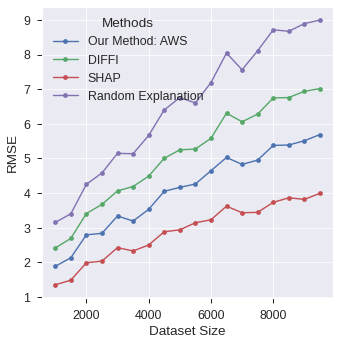

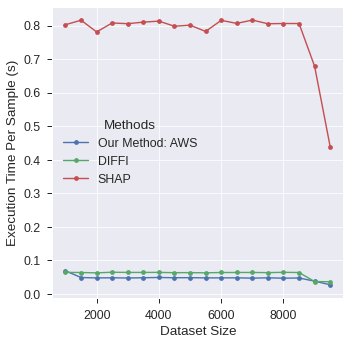

In [ ]:
exp1_main, exp1_support = run_experiment_batch(exp_string = 'syn1', max_points=10000)

###Experiment 2: Increasing Dataset Dimensionality

We compare the RMSE loss of the explanation vectors produced by the 3 methods with increasing synthetic dataset dimensionality.

[INFO] Iteration 1: Dataset Dimensionality - 2 features...
[INFO] Iteration 4: Dataset Dimensionality - 8 features...
[INFO] Iteration 2: Dataset Dimensionality - 4 features...
[INFO] Iteration 5: Dataset Dimensionality - 10 features...
[INFO] Iteration 3: Dataset Dimensionality - 6 features...
[INFO] Iteration 6: Dataset Dimensionality - 12 features...
[INFO] Iteration 7: Dataset Dimensionality - 14 features...
[INFO] Iteration 10: Dataset Dimensionality - 20 features...
[INFO] Iteration 8: Dataset Dimensionality - 16 features...
[INFO] Iteration 11: Dataset Dimensionality - 22 features...
[INFO] Iteration 9: Dataset Dimensionality - 18 features...
[INFO] Iteration 12: Dataset Dimensionality - 24 features...
[INFO] Iteration 13: Dataset Dimensionality - 26 features...
[INFO] Iteration 16: Dataset Dimensionality - 32 features...
[INFO] Iteration 14: Dataset Dimensionality - 28 features...
[INFO] Iteration 17: Dataset Dimensionality - 34 features...
[INFO] Iteration 15: Dataset Dimensio

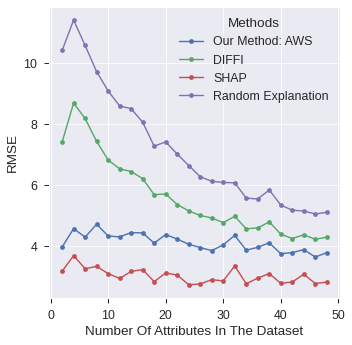

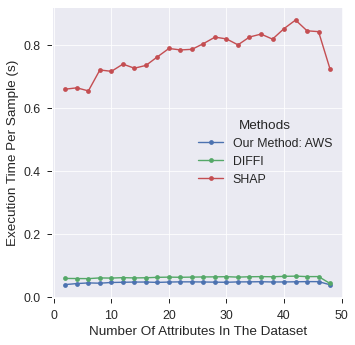

In [ ]:
exp2_main, exp2_support = run_experiment_batch(exp_string = 'syn2',max_features=50)

###Experiment 3: Increasing Anomalous Features

We compare the RMSE loss of the explanation vectors produced by the 3 methods as we increase the number of features in the synthetic dataset, which are getting anomalised.

[INFO] Iteration 1: Upto 1 features anomalised for dataset of 5,000 samples with 25 features...
[INFO] Iteration 4: Upto 4 features anomalised for dataset of 5,000 samples with 25 features...
[INFO] Iteration 5: Upto 5 features anomalised for dataset of 5,000 samples with 25 features...
[INFO] Iteration 2: Upto 2 features anomalised for dataset of 5,000 samples with 25 features...
[INFO] Iteration 6: Upto 6 features anomalised for dataset of 5,000 samples with 25 features...
[INFO] Iteration 3: Upto 3 features anomalised for dataset of 5,000 samples with 25 features...
[INFO] Iteration 7: Upto 7 features anomalised for dataset of 5,000 samples with 25 features...
[INFO] Iteration 10: Upto 10 features anomalised for dataset of 5,000 samples with 25 features...
[INFO] Iteration 8: Upto 8 features anomalised for dataset of 5,000 samples with 25 features...
[INFO] Iteration 11: Upto 11 features anomalised for dataset of 5,000 samples with 25 features...
[INFO] Iteration 9: Upto 9 features 

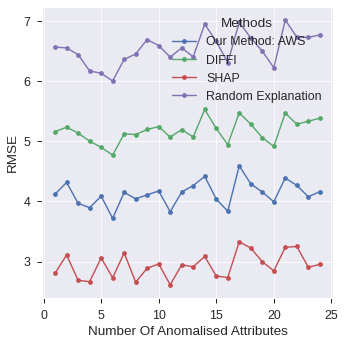

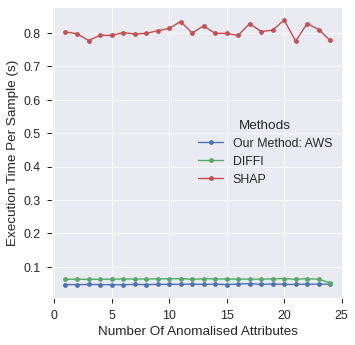

In [ ]:
exp3_main, exp3_support = run_experiment_batch(exp_string = 'syn3')

## Real world Datasets

Within the same experimental framework, we perform our loss and execution time tracking experiments on the real-world datasets mentioned in the DIFFI paper.


1.   'satellite'
2.   'cardio'
3. 'ionosphere'
4. 'lympho'
5. 'musk'
6. 'letter'
7. Glass Identification Dataset




### 1.1) Glass Identification Dataset

**Abstract**: From USA Forensic Science Service; 6 types of glass; defined in terms of their oxide content (i.e. Na, Fe, K, etc). More details of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/glass+identification).



In [ ]:

#Load the dataset to a dataframe
glass_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data',
                       header=None, index_col=0)
glass_data, target = glass_df.iloc[:, :-1], glass_df.iloc[:, [-1]]
glass_data_new_array = StandardScaler().fit_transform(glass_data.values)

glass_id2feat = {0:'RI', 1:'Na', 2:'Mg', 3:'Al', 4:'Si', 5:'K', 6:'Ca', 7:'Ba', 8:'Fe'}
glass_df_std = pd.DataFrame(glass_data_new_array, columns=list(glass_id2feat.values()))
glass_df_std.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,0.872868,0.284953,1.254639,-0.692442,-1.127082,-0.671705,-0.145766,-0.352877,-0.586451
1,-0.249333,0.591817,0.636168,-0.170460,0.102319,-0.026213,-0.793734,-0.352877,-0.586451
2,-0.721318,0.149933,0.601422,0.190912,0.438787,-0.164533,-0.828949,-0.352877,-0.586451
3,-0.232831,-0.242853,0.698710,-0.310994,-0.052974,0.112107,-0.519052,-0.352877,-0.586451
4,-0.312045,-0.169205,0.650066,-0.411375,0.555256,0.081369,-0.624699,-0.352877,-0.586451


In [ ]:
glass_main, glass_support = run_experiment_batch(exp_string = 'real2_Glass', data = glass_df_std)

###1.2) Cardio

**Abstract**: The dataset consists of measurements of fetal heart rate (FHR) and uterine contraction (UC) features on cardiotocograms classified by expert obstetricians. More details of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/cardiotocography).


Loaded cardio dataset: 1831 samples, 21 features.
9.61 percent outliers.
[INFO] Iteration 4: Upto 4 features anomalised for Cardio dataset (1831 samples and 21 features)...
[INFO] Iteration 1: Upto 1 features anomalised for Cardio dataset (1831 samples and 21 features)...
[INFO] Iteration 5: Upto 5 features anomalised for Cardio dataset (1831 samples and 21 features)...
[INFO] Iteration 2: Upto 2 features anomalised for Cardio dataset (1831 samples and 21 features)...
[INFO] Iteration 6: Upto 6 features anomalised for Cardio dataset (1831 samples and 21 features)...
[INFO] Iteration 3: Upto 3 features anomalised for Cardio dataset (1831 samples and 21 features)...
[INFO] Iteration 7: Upto 7 features anomalised for Cardio dataset (1831 samples and 21 features)...
[INFO] Iteration 10: Upto 10 features anomalised for Cardio dataset (1831 samples and 21 features)...
[INFO] Iteration 8: Upto 8 features anomalised for Cardio dataset (1831 samples and 21 features)...
[INFO] Iteration 11: Upt

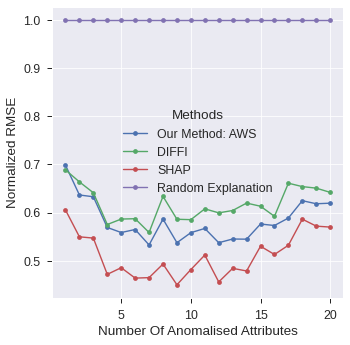

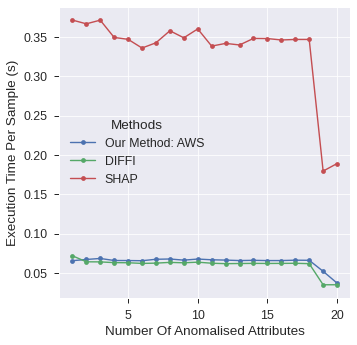

In [ ]:
#Change cwd to DIFFI
os.chdir('/content/DIFFI')
dataset_id = 'cardio' # 'musk', 'satellite', 'lympho', 'letter', 'ionosphere', 'cardio'

#Load the dataset to a numpy array
cardio_X, y, cardio_contamination = utils.get_fs_dataset(dataset_id, seed=42)
hyper = utils.fs_datasets_hyperparams(dataset_id)
cardio_X_std = StandardScaler().fit_transform(cardio_X)
cardio_df_std = pd.DataFrame(cardio_X_std)

#Run the experiment
cardio_main, cardio_support = run_experiment_batch(exp_string = 'real2_Cardio', n_est=hyper['n_estimators'], max_samples=hyper['max_samples'],
                                                   data = cardio_df_std, contam_rate=cardio_contamination)
#cardio_main1, cardio_support1 = run_experiment_batch(exp_string = 'real2_Cardio', data = cardio_df_std, n_est=hyper['n_estimators'], max_samples=hyper['max_samples'],
#                                                   contam_rate=cardio_contamination, r_mode='a')

###1.3) Ionosphere

**Abstract**: Classification of radar returns from the ionosphere.More details of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/ionosphere)




Loaded ionosphere dataset: 351 samples, 33 features.
35.90 percent outliers.
[INFO] Iteration 1: Upto 1 features anomalised for Ionosphere dataset (351 samples and 33 features)...
[INFO] Iteration 5: Upto 5 features anomalised for Ionosphere dataset (351 samples and 33 features)...
[INFO] Iteration 6: Upto 6 features anomalised for Ionosphere dataset (351 samples and 33 features)...
[INFO] Iteration 2: Upto 2 features anomalised for Ionosphere dataset (351 samples and 33 features)...
[INFO] Iteration 7: Upto 7 features anomalised for Ionosphere dataset (351 samples and 33 features)...
[INFO] Iteration 3: Upto 3 features anomalised for Ionosphere dataset (351 samples and 33 features)...
[INFO] Iteration 4: Upto 4 features anomalised for Ionosphere dataset (351 samples and 33 features)...
[INFO] Iteration 8: Upto 8 features anomalised for Ionosphere dataset (351 samples and 33 features)...
[INFO] Iteration 9: Upto 9 features anomalised for Ionosphere dataset (351 samples and 33 features

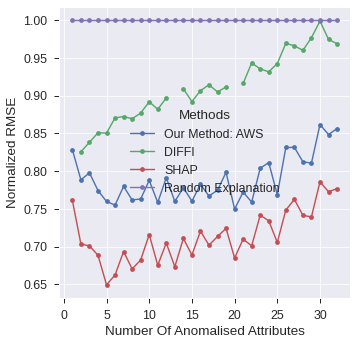

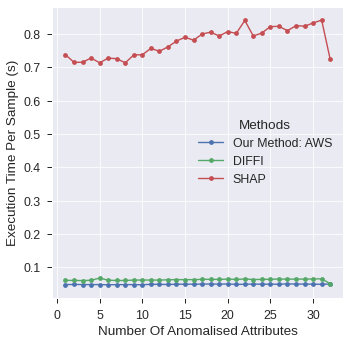

In [ ]:
#Change cwd to DIFFI
os.chdir('/content/DIFFI')
dataset_id = 'ionosphere' # 'musk', 'satellite', 'lympho', 'letter', 'ionosphere', 'cardio'

#Load the dataset to a numpy array
iono_X, y, iono_contamination = utils.get_fs_dataset(dataset_id, seed=42)
hyper = utils.fs_datasets_hyperparams(dataset_id)
iono_X_std = StandardScaler().fit_transform(iono_X)
iono_df_std = pd.DataFrame(iono_X_std)

#Run the experiment
iono_main, iono_support = run_experiment_batch(exp_string = 'real2_Ionosphere', data = iono_df_std, n_est=hyper['n_estimators'], max_samples=hyper['max_samples'],
                                                   contam_rate=iono_contamination)
#iono_main1, iono_support1 = run_experiment_batch(exp_string = 'real2_Ionosphere', data = iono_df_std, n_est=hyper['n_estimators'], max_samples=hyper['max_samples'],
#                                                   contam_rate=iono_contamination, r_mode='a')

###1.4) Lympho

**Abstract**: This lymphography domain was obtained from the University Medical Centre, Institute of Oncology, Ljubljana, Yugoslavia. More details of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Lymphography)


Loaded lympho dataset: 148 samples, 18 features.
4.05 percent outliers.
[INFO] Iteration 1: Upto 1 features anomalised for Lympho dataset (148 samples and 18 features)...
[INFO] Iteration 4: Upto 4 features anomalised for Lympho dataset (148 samples and 18 features)...
[INFO] Iteration 5: Upto 5 features anomalised for Lympho dataset (148 samples and 18 features)...
[INFO] Iteration 2: Upto 2 features anomalised for Lympho dataset (148 samples and 18 features)...
[INFO] Iteration 6: Upto 6 features anomalised for Lympho dataset (148 samples and 18 features)...
[INFO] Iteration 3: Upto 3 features anomalised for Lympho dataset (148 samples and 18 features)...
[INFO] Iteration 7: Upto 7 features anomalised for Lympho dataset (148 samples and 18 features)...
[INFO] Iteration 10: Upto 10 features anomalised for Lympho dataset (148 samples and 18 features)...
[INFO] Iteration 8: Upto 8 features anomalised for Lympho dataset (148 samples and 18 features)...
[INFO] Iteration 11: Upto 11 featu

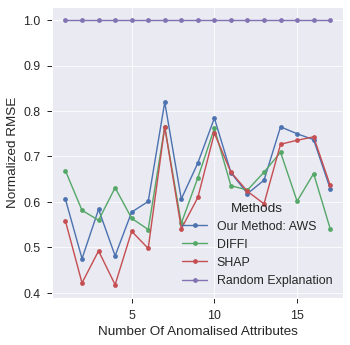

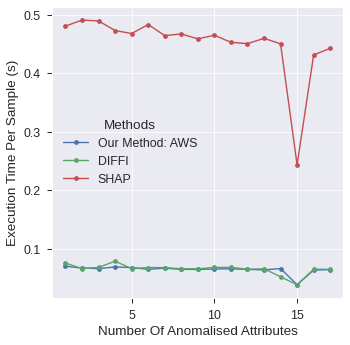

In [ ]:
#Change cwd to DIFFI
os.chdir('/content/DIFFI')
dataset_id = 'lympho' # 'musk', 'satellite', 'lympho', 'letter', 'ionosphere', 'cardio'

#Load the dataset to a numpy array
lympho_X, y, lympho_contamination = utils.get_fs_dataset(dataset_id, seed=42)
hyper = utils.fs_datasets_hyperparams(dataset_id)
lympho_X_std = StandardScaler().fit_transform(lympho_X)
lympho_df_std = pd.DataFrame(lympho_X_std)

#Run the experiment
lympho_main, lympho_support = run_experiment_batch(exp_string = 'real2_Lympho', data = lympho_df_std, n_est=hyper['n_estimators'], max_samples=hyper['max_samples'],
                                                   contam_rate=lympho_contamination)
#lympho_main1, lympho_support1 = run_experiment_batch(exp_string = 'real2_Lympho', data = lympho_df_std, n_est=hyper['n_estimators'], max_samples=hyper['max_samples'],
#                                                   contam_rate=lympho_contamination, r_mode='a')

###1.5) Musk

**Abstract**: The goal is to learn to predict whether new molecules will be musks or non-musks. More details of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Musk+(Version+2))


Loaded musk dataset: 3062 samples, 166 features.
3.17 percent outliers.
[INFO] Iteration 1: Upto 1 features anomalised for Cardio dataset (3062 samples and 166 features)...
[INFO] Iteration 22: Upto 22 features anomalised for Cardio dataset (3062 samples and 166 features)...
[INFO] Iteration 23: Upto 23 features anomalised for Cardio dataset (3062 samples and 166 features)...
[INFO] Iteration 2: Upto 2 features anomalised for Cardio dataset (3062 samples and 166 features)...
[INFO] Iteration 24: Upto 24 features anomalised for Cardio dataset (3062 samples and 166 features)...
[INFO] Iteration 3: Upto 3 features anomalised for Cardio dataset (3062 samples and 166 features)...
[INFO] Iteration 25: Upto 25 features anomalised for Cardio dataset (3062 samples and 166 features)...
[INFO] Iteration 4: Upto 4 features anomalised for Cardio dataset (3062 samples and 166 features)...
[INFO] Iteration 26: Upto 26 features anomalised for Cardio dataset (3062 samples and 166 features)...
[INFO] I

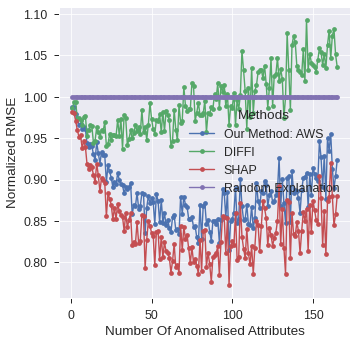

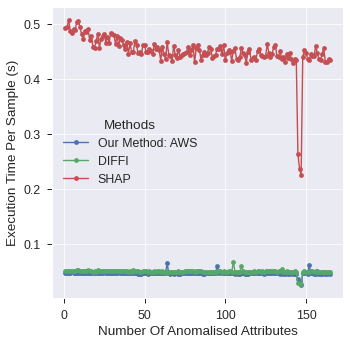

In [ ]:
#Change cwd to DIFFI
os.chdir('/content/DIFFI')
dataset_id = 'musk' # 'musk', 'satellite', 'lympho', 'letter', 'ionosphere', 'cardio'

#Load the dataset to a numpy array
musk_X, y, musk_contamination = utils.get_fs_dataset(dataset_id, seed=42)
hyper = utils.fs_datasets_hyperparams(dataset_id)
musk_X_std = StandardScaler().fit_transform(musk_X)
musk_df_std = pd.DataFrame(musk_X_std)

#Run the experiment
musk_main, musk_support = run_experiment_batch(exp_string = 'real2_Cardio', n_est=hyper['n_estimators'], max_samples=hyper['max_samples'],
                                                   data = musk_df_std, contam_rate=musk_contamination)
#musk_main1, musk_support1 = run_experiment_batch(exp_string = 'real2_Cardio', data = musk_df_std, n_est=hyper['n_estimators'], max_samples=hyper['max_samples'],
#                                                   contam_rate=musk_contamination, r_mode='a')

###1.6) Letter

**Abstract**: Database of character image features; try to identify the letter. More details of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Letter+Recognition)


Loaded letter dataset: 1600 samples, 32 features.
6.25 percent outliers.
[INFO] Iteration 1: Upto 1 features anomalised for Letter dataset (1600 samples and 32 features)...
[INFO] Iteration 5: Upto 5 features anomalised for Letter dataset (1600 samples and 32 features)...
[INFO] Iteration 6: Upto 6 features anomalised for Letter dataset (1600 samples and 32 features)...
[INFO] Iteration 2: Upto 2 features anomalised for Letter dataset (1600 samples and 32 features)...
[INFO] Iteration 7: Upto 7 features anomalised for Letter dataset (1600 samples and 32 features)...
[INFO] Iteration 3: Upto 3 features anomalised for Letter dataset (1600 samples and 32 features)...
[INFO] Iteration 8: Upto 8 features anomalised for Letter dataset (1600 samples and 32 features)...
[INFO] Iteration 4: Upto 4 features anomalised for Letter dataset (1600 samples and 32 features)...
[INFO] Iteration 9: Upto 9 features anomalised for Letter dataset (1600 samples and 32 features)...
[INFO] Iteration 13: Upto 

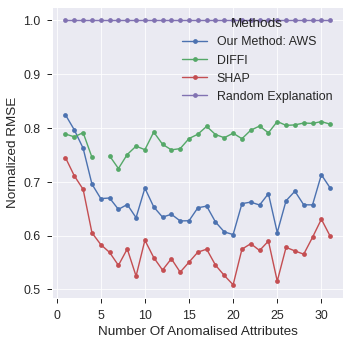

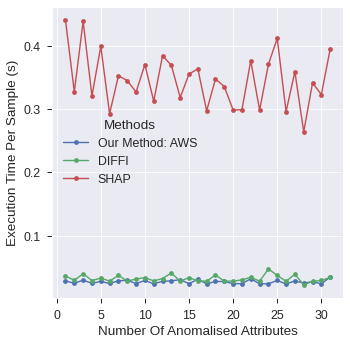

In [ ]:
#Change cwd to DIFFI
os.chdir('/content/DIFFI')
dataset_id = 'letter' # 'musk', 'satellite', 'lympho', 'letter', 'ionosphere', 'cardio'

#Load the dataset to a numpy array
letter_X, y, letter_contamination = utils.get_fs_dataset(dataset_id, seed=42)
hyper = utils.fs_datasets_hyperparams(dataset_id)
letter_X_std = StandardScaler().fit_transform(letter_X)
letter_df_std = pd.DataFrame(letter_X_std)

#Run the experiment
letter_main, letter_support = run_experiment_batch(exp_string = 'real2_Letter', data = letter_df_std, n_est=hyper['n_estimators'], max_samples=hyper['max_samples'],
                                                   contam_rate=letter_contamination)
#letter_main1, letter_support1 = run_experiment_batch(exp_string = 'real2_Letter', data = letter_df_std, n_est=hyper['n_estimators'], max_samples=hyper['max_samples'],
#                                                   contam_rate=letter_contamination, r_mode='a')

## Heatmap

We illustrate in a toy example how a key difference in how local DIFFI and our AWS method assigns weights to splits, impacts the explanation provided by both methods, and argue that our method addresses a shortcoming of the DIFFI weighting scheme. 

Below are heatmaps representing the contribution of the each attribute to the anomaly score (blue = X1 and red = X2). 

For each plot, one cluster lies on the bottom left and the other in the top right quadrant of the plot. Explanation vectors are normalised
so their values sum to 1. 

When the IFOREST is retrained for each heatmap point, we say that the setting is **in-bag (IB)**, as the data point is part of the trained
IFOREST. When the IFOREST is not retrained, the setting is said to be **out-of-bag (OOB)**. When there are anomalies in the training data, the setting is with **anomalies (A)**. When there are no anomalies in the training data, the setting is said to be **no anomalies (No-A)**. There are therefore **a total of 4 settings** for each method.

In [ ]:
def run_heatmap_experiment(ano_indicator=True, in_bag=True, n_exp=1):
    
    rng = np.random.RandomState(seed_val)
    
    #Keep track of the negative values
    neg_dict = {}
    neg_dict_l = []
    
    #Define the starting dataset
    min_val = -2
    max_val = 2
    X = 0.3 * rng.randn(100, 2)
    initial_dataset = np.r_[X + max_val, X + min_val]
    colors = ["c"] * 200
    if ano_indicator:
        ano_points = rng.uniform(low=-4, high=4, size=(20, 2))
        initial_dataset = np.r_[initial_dataset, ano_points]
        colors.extend(["tab:pink"]*20)
    
    #Create meshgrid of possible combinations
    nx = 100
    x = np.linspace(-5, 5, nx)
    y = np.linspace(-5, 5, nx)
    
    aws_matrix_final = np.zeros(shape=(len(x), len(y)))
    aws_matrix_temp = np.zeros(shape=(len(x), len(y)))
    aws_matrix_collection = np.zeros(shape=(n_exp, len(x), len(y)))
    
    diffi_matrix_final = np.zeros(shape=(len(x), len(y)))
    diffi_matrix_temp = np.zeros(shape=(len(x), len(y)))
    diffi_matrix_collection = np.zeros(shape=(n_exp, len(x), len(y)))
    
    for i in range(n_exp):
      
        #Fit an IF model to this starting dataset
        clf = IsolationForest(n_estimators=100, random_state=rng, max_samples=256)
        clf.fit(initial_dataset)
        
        #Loop through possible coordinates starting at normal
        for j, element in enumerate(list(itertools.product(x, y))):
            
            x_val = element[0]
            y_val = element[1]
            
            #If ano, fit the IF to the new dataset with the point
            if in_bag:
                del clf
                clf = IsolationForest(n_estimators=100, random_state=rng, max_samples=256)
                clf.fit(np.r_[initial_dataset, np.array([[x_val, y_val]])])
                    
            #Generate explanations - AWS, DIFFI
            aws_unnorm, _ = point_aws_explanation(clf, np.array([x_val, y_val]), False, 'clement')
            diffi_unnorm, _ = interp.local_diffi(clf, np.array([x_val, y_val]))
        
            #Check whether the AWS vector has any negative value
            if (aws_unnorm < 0).any():
                neg_dict[(x_val, y_val)] = 1
                aws_unnorm[aws_unnorm < 0] = 0
            
            #Process the explanation vectors
            aws_norm = aws_unnorm/np.sum(aws_unnorm)
            diffi_norm = diffi_unnorm/np.sum(diffi_unnorm)
    
            #Append to some array-like object for both AWS and DIFFI
            x_index = j % nx
            y_index = j // nx
            aws_matrix_temp[x_index, y_index] = aws_norm[0]
            diffi_matrix_temp[x_index, y_index] = diffi_norm[0]
            
        neg_dict_l.append(neg_dict)
        aws_matrix_collection[i] = aws_matrix_temp
        diffi_matrix_collection[i] = diffi_matrix_temp
    
    #Append to some array-like object for both AWS and DIFFI
    aws_matrix_final = np.mean(aws_matrix_collection, axis=0)
    diffi_matrix_final = np.mean(diffi_matrix_collection, axis=0)
        
    #Plotting function for both AWS & DIFFI arrays
    #x and y should be X1 and X2. cmap should be between 0(Red, X1=0, X2=1) and 1 (Blue.X1=1, X2=0)
    #x,y discretized to meshgrid
    # plot the line, the samples, and the nearest vectors to the plane
    xx, yy = np.meshgrid(x, y)
    aws_matrix_final = aws_matrix_final.reshape(xx.shape)
    diffi_matrix_final = diffi_matrix_final.reshape(xx.shape)
    
    aws_save_name = "AWS_" + "ano_" + str(ano_indicator) + "_inbag" + str(in_bag) + ".pdf"
    diffi_save_name = "DIFFI_" + "ano_" + str(ano_indicator) + "_inbag" + str(in_bag) + ".pdf"
    
    os.chdir(dir_path)
    
    plt.close()
    plt.style.use('seaborn')
    sns.set_context("talk", font_scale=1.5)
    plt.contourf(xx, yy, aws_matrix_final, cmap=plt.cm.RdBu, vmin=0, vmax=1)
    m = plt.cm.ScalarMappable(cmap=plt.cm.RdBu)
    m.set_array(aws_matrix_final)
    m.set_clim(0., 1.)
    plt.colorbar(m, boundaries=np.linspace(0, 1, 11))
    plt.scatter(initial_dataset[:, 0], initial_dataset[:, 1], c=colors, s=80, edgecolor='k')
    
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.tick_params(top=False, bottom=False, left=False, right=False,
               labelleft=False, labelbottom=False)
    plt.show()
    if save_files:
      plt.savefig('contour_' + aws_save_name, bbox_inches='tight')
    
    plt.close()
    plt.style.use('seaborn')
    sns.set_context("talk", font_scale=1.5)
    plt.contourf(xx, yy, diffi_matrix_final, cmap=plt.cm.RdBu, vmin=0, vmax=1)
    m = plt.cm.ScalarMappable(cmap=plt.cm.RdBu)
    m.set_array(diffi_matrix_final)
    m.set_clim(0., 1.)
    plt.colorbar(m, boundaries=np.linspace(0, 1, 11))
    plt.scatter(initial_dataset[:, 0], initial_dataset[:, 1], c=colors, s=80, edgecolor='k')
    
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.tick_params(top=False, bottom=False, left=False, right=False,
               labelleft=False, labelbottom=False)
    plt.show()
    if save_files:
      plt.savefig('contour_' + diffi_save_name, bbox_inches='tight') 
    
    return neg_dict_l, aws_matrix_final, diffi_matrix_final

**Setting #1/4**: In-bag, Anomalies

The first heatmap corresponds to AWS and the second heatmap corresponds to local DIFFI.

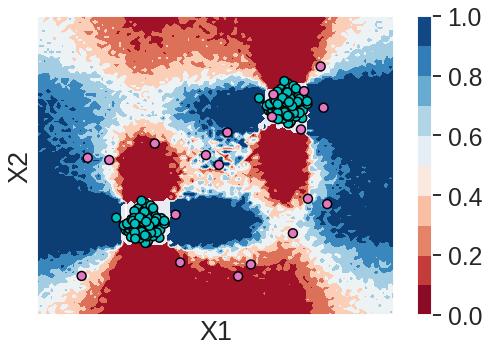

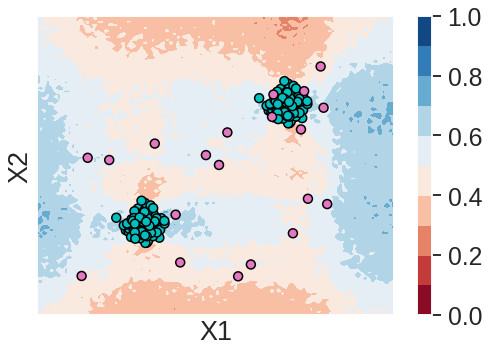

<Figure size 576x396 with 0 Axes>

In [ ]:
neg_dict_l_ano_inbag, aws_mat_ano_inbag, diffi_mat_ano_inbag = run_heatmap_experiment(True, True)

**Setting #2/4**: Out-of-bag, Anomalies

The first heatmap corresponds to AWS and the second heatmap corresponds to local DIFFI.

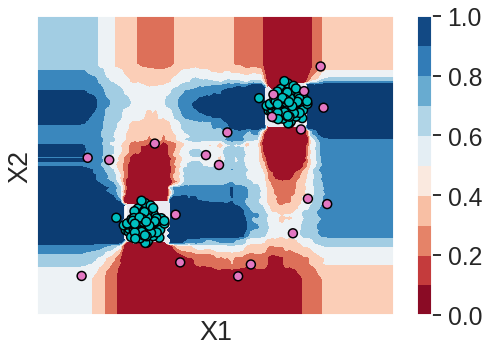

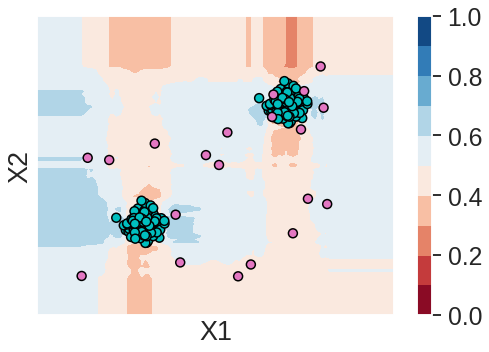

<Figure size 576x396 with 0 Axes>

In [ ]:
neg_dict_l_ano_outbag, aws_mat_ano_outbag, diffi_mat_ano_outbag = run_heatmap_experiment(True, False)

**Setting #3/4**: In-bag, No-Anomalies

The first heatmap corresponds to AWS and the second heatmap corresponds to local DIFFI.

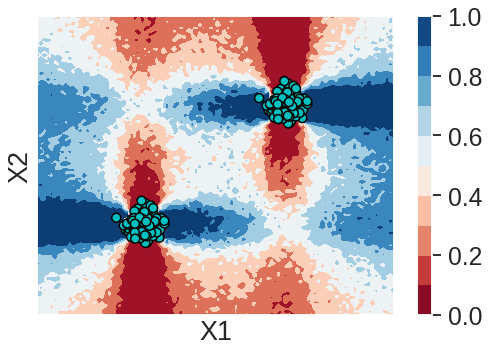

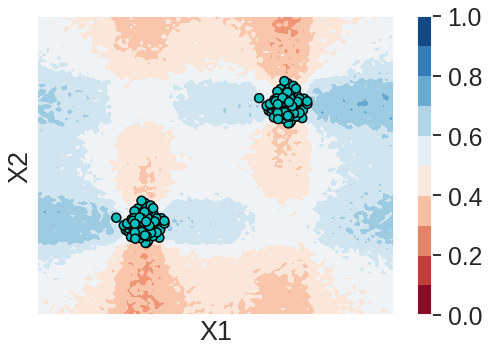

<Figure size 576x396 with 0 Axes>

In [ ]:
neg_dict_l_no_ano_inbag, aws_mat_no_ano_inbag, diffi_mat_no_ano_inbag = run_heatmap_experiment(False, True)

**Setting #4/4**: Out-bag, No-Anomalies

The first heatmap corresponds to AWS and the second heatmap corresponds to local DIFFI.

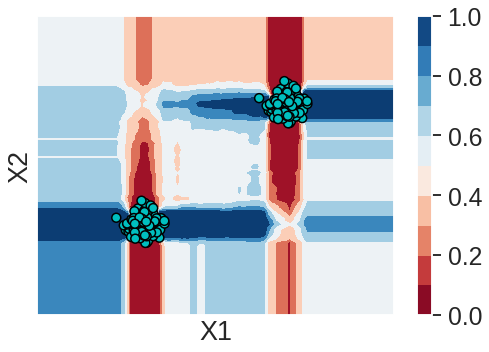

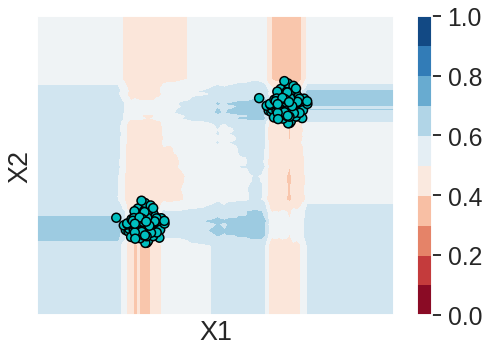

<Figure size 576x396 with 0 Axes>

In [ ]:
neg_dict_l_no_ano_outbag, aws_mat_no_ano_outbag, diffi_mat_no_ano_outbag = run_heatmap_experiment(False, False)

In [ ]:
results_dict = {}

results_dict['aws_ano_inbag'] = aws_mat_ano_inbag
results_dict['diffi_ano_inbag'] = diffi_mat_ano_inbag

results_dict['aws_ano_outbag'] = aws_mat_ano_outbag
results_dict['diffi_ano_outbag'] = diffi_mat_ano_outbag

results_dict['aws_no_ano_inbag'] = aws_mat_no_ano_inbag
results_dict['diffi_no_ano_inbag'] = diffi_mat_no_ano_inbag

results_dict['aws_no_ano_outbag'] = aws_mat_no_ano_outbag
results_dict['diffi_no_ano_outbag'] = diffi_mat_no_ano_outbag

if save_files:
  os.chdir(dir_path)
  with open("heatmap_results.pickle", 'wb') as out_file:
    pickle.dump(results_dict, out_file)